In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tqdm import tqdm

from energymodel import (
    EnergyModel, random_uniform, RandomWalk,
    LossMonitor, FantasyParticleMonitor, VectorFieldMonitor, LossGradientMonitor,
)

tf.compat.v1.reset_default_graph()

C:\Users\shuir\scoop\apps\miniconda3\current\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Dataset

In [2]:
(dataset, _), info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

def filter_img(image, label):
    return image

def normalize_img(image):
    return 2 * tf.cast(image, 'float32') / 255 - 1

def reshape_img(image):
    return tf.reshape(image, [28, 28, 1])

def preprocess_dataset(dataset, batch_size):
    return (
        dataset
        .map(filter_img, num_parallel_calls=tf.data.AUTOTUNE)
        .map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
        .map(reshape_img, num_parallel_calls=tf.data.AUTOTUNE)
        .cache()
        .shuffle(info.splits['train'].num_examples)
        .batch(batch_size)
        .prefetch(tf.data.AUTOTUNE)
    )

batch_size = 128
dataset = preprocess_dataset(dataset, batch_size)

## Model

In [3]:
# We employ LeNet-like CNN as the network.
# The activation function are changed from tanh to swish;
# and the top dense layers are slightly adjusted. Output layer
# has to be Dense(1, use_bias=False)

from site import USER_BASE


network = models.Sequential([
    layers.Conv2D(6, kernel_size=5, strides=1, padding='same'),
    layers.Activation('swish'),
    layers.AveragePooling2D(pool_size=2, strides=2, padding='valid'),

    layers.Conv2D(16, kernel_size=5, strides=1, padding='valid'),
    layers.Activation('swish'),
    layers.AveragePooling2D(pool_size=2, strides=2, padding='valid'),

    layers.Flatten(),

    layers.Dense(256),
    layers.Activation('swish'),

    layers.Dense(64),
    layers.Activation('swish'),

    layers.Dense(1, use_bias=False),
])
input_shape = [28, 28, 1]
network.build([None, *input_shape])
fantasy_particles = random_uniform([batch_size, *input_shape])

In [4]:
!rm -rf ./logdir

'rm' is not recognized as an internal or external command,
operable program or batch file.


In [5]:
model = EnergyModel(
    network,
    fantasy_particles,
    resample=lambda x: random_uniform(tf.shape(x)),
)

optimizer = tf.keras.optimizers.Adam(1e-3, clipvalue=1e-1)
random_walk = RandomWalk.get_proper_instance(5e-0, 1e-1, 1e-1)
tf.print('T = ', random_walk.T)
writer = tf.summary.create_file_writer('./logdir')
callbacks = [
    LossMonitor(writer, 5),
    FantasyParticleMonitor(writer, model, 5),
    VectorFieldMonitor(writer, model, 5),
    LossGradientMonitor(writer, model, 5),
]

train_step = model.get_optimize_fn(optimizer, random_walk, callbacks)
train_step = tf.function(train_step)

T =  0.025


In [24]:
# Two epochs are enough!
for epoch in range(2):
    for batch in tqdm(dataset):
        train_step(batch)

100%|██████████| 469/469 [07:25<00:00,  1.05it/s]


## Evaluation

In [25]:
test_X = list(dataset)[0]

In [71]:
# If test denoise:
noised_X = test_X + 0.5 * tf.random.truncated_normal(test_X.shape)

# Or if test generation:
# noised_X = random_uniform(test_X.shape)

relaxed_X = model(noised_X, random_walk)

In [72]:
def display_image(x):
    x = x.numpy().reshape([28, 28])
    plt.imshow(x)
    plt.show()

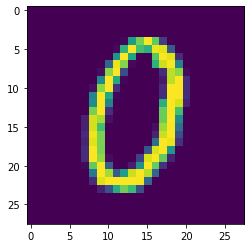

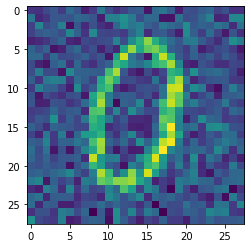

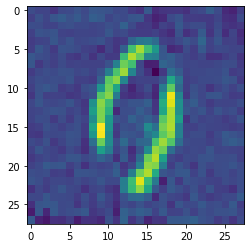

In [74]:
i = 1
display_image(test_X[i, :])
display_image(noised_X[i, :])
display_image(relaxed_X[i, :])

## Conclusions

TODO

### Instability

### Persistance
